### Modeling

1. ARIMA(1, 1, 1)

    : $ Y_{i}  = \phi Y_{i-1} + \sigma_{i} + \gamma \sigma_{i-1} $

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
import seaborn as sns
import statsmodels.api as sm

In [7]:
# load data
df = pd.read_excel("core_data.xlsx")

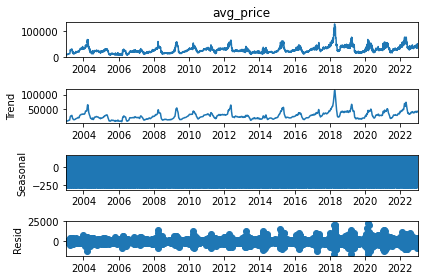

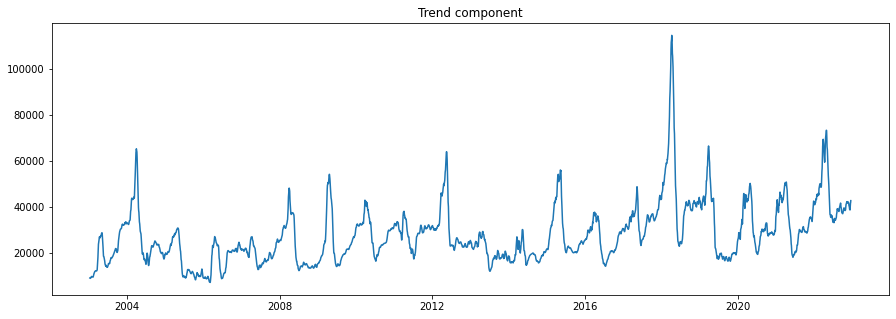

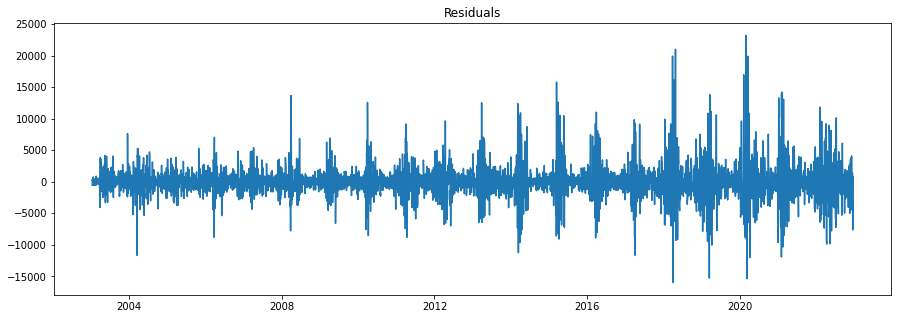

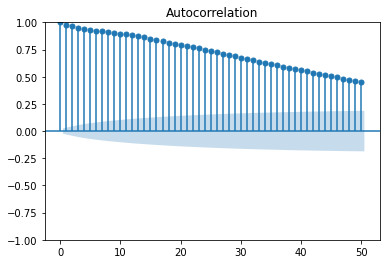

C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


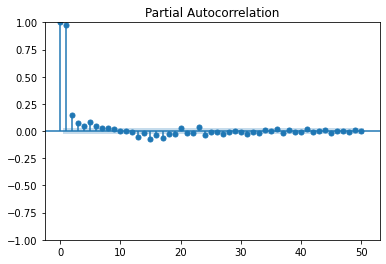

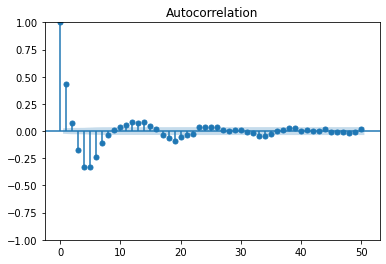

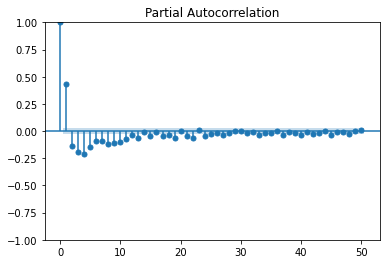

ADF Statistic: -6.608227390290976
p-value: True
ADF Statistic: -15.005541174993445
p-value: True


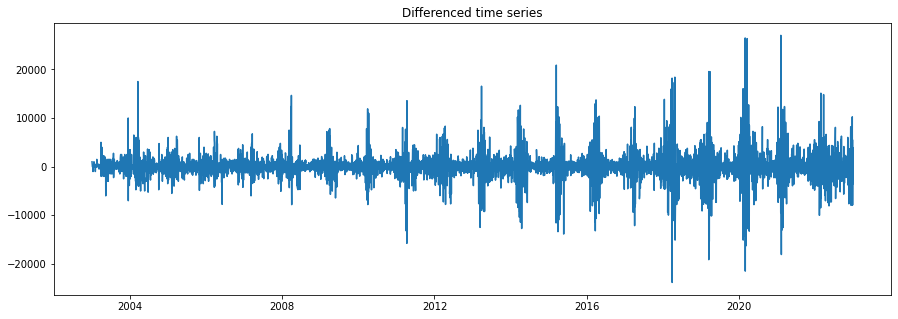

C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will b

KPSS Statistic: 3.07761244324307
p-value: True
KPSS Statistic: 0.0073394150818292606
p-value: False


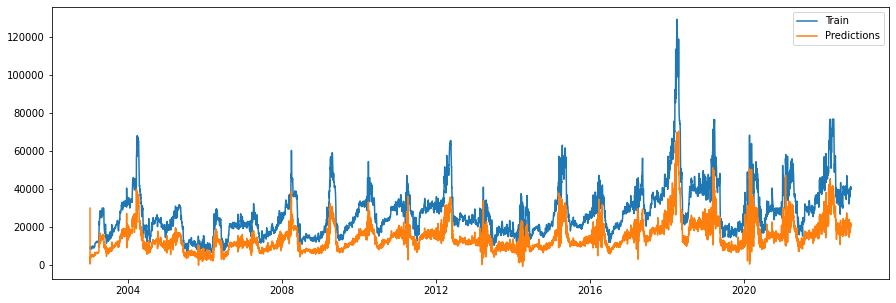

MSE: 215746072.1153923


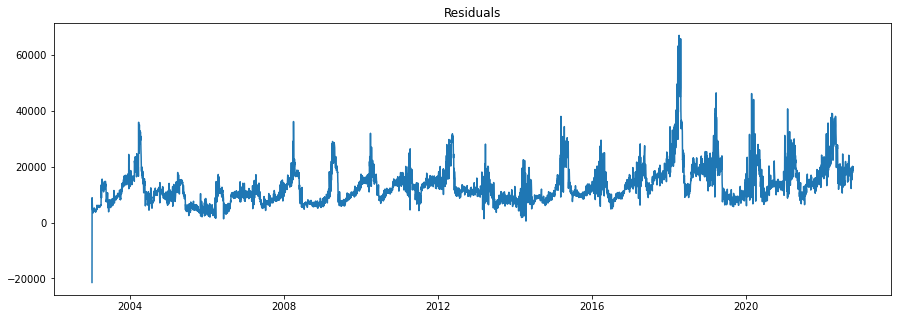

MSE: 383378977.4527616


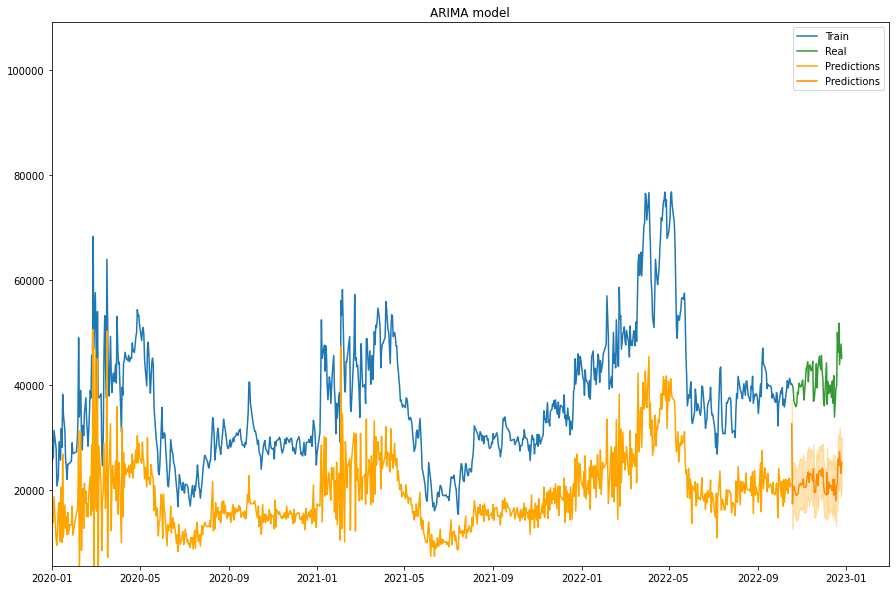

In [ ]:

# time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# set the date as index
df.set_index("DATE", inplace=True)

# decompose the time series
decomposition = seasonal_decompose(df["avg_price"], model="additive", period=12)
decomposition.plot()
plt.show()

# plot the trend component
plt.figure(figsize=(15, 5))
plt.plot(decomposition.trend)
plt.title("Trend component")
plt.show()

# plot the residuals
plt.figure(figsize=(15, 5))
plt.plot(decomposition.resid)
plt.title("Residuals")
plt.show()

# plot the autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df["avg_price"], lags=50)
plt.show()

plot_pacf(df["avg_price"], lags=50)
plt.show()

# plot the autocorrelation of the residuals
plot_acf(decomposition.resid.dropna(), lags=50)
plt.show()

plot_pacf(decomposition.resid.dropna(), lags=50)
plt.show()

# stationarity test ------------------------------
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["avg_price"])
print("ADF Statistic:", result[0]) # -6.608227390290976
print("p-value:", result[1] < 0.05) # True

# differencing
df["diff"] = df["avg_price"].diff()
result = adfuller(df["diff"].dropna())

print("ADF Statistic:", result[0]) # -15.005541174993445
print("p-value:", result[1] < 0.05) # True
#---------------------------------------------------

#plot the differenced time series
plt.figure(figsize=(15, 5))
plt.plot(df["diff"])
plt.title("Differenced time series")
plt.show()

# KPSS test------------------------------
from statsmodels.tsa.stattools import kpss

result = kpss(df["avg_price"])
print("KPSS Statistic:", result[0]) # 3.07761244324307
print("p-value:", result[1] < 0.05) # True

df["diff"] = df["avg_price"].diff() 
result = kpss(df["diff"].dropna()) 

print("KPSS Statistic:", result[0]) # 0.0073394150818292606
print("p-value:", result[1] < 0.05) # False 
#-----------------------------------------

# ARIMA model----------------------------
from statsmodels.tsa.arima.model import ARIMA

# training set 
train = df["avg_price"].iloc[:-60]

# test set
test = test = df["avg_price"].iloc[-60:]

# fit the ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model = model.fit()

# coefficients
sigma = model.params[1]
phi = model.params[0]

# residuals
residuals = model.resid

# construct ARIMA model 
preds = []
for i in range(len(train)):
    pred = phi * train[i-1] + sigma * residuals[i-1] + residuals[i]
    preds.append(pred)
    
# to dataframe, index is test data index
preds = pd.Series(preds, index=train.index)
    
# plot the predictions
plt.figure(figsize=(15, 5))
plt.plot(train, label="Train")
plt.plot(preds, label="Predictions")
plt.legend()
plt.show()

# evaluate the model
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(train, preds)
print("MSE:", mse)

# plot the residuals
plt.figure(figsize=(15, 5))
plt.plot(train - preds)
plt.title("Residuals")
plt.show()
#-------------------------------------

# test the model ----------------------------------
real = df["avg_price"].iloc[-60:]

y_pred = []
for i in range(len(test)):
    pred = phi * test[i-1] + sigma * residuals[i-1] + residuals[i]
    y_pred.append(pred)
    
# dataframe with index as test data index
y_pred = pd.Series(y_pred, index=test.index)

# confidence intervals by y_pred +- 1.96 * sigma
sigma_test = sqrt(y_pred.var())
lower = y_pred - 1.96 * sigma_test
upper = y_pred + 1.96 * sigma_test

# evaluate the model
mse = mean_squared_error(real, y_pred)
print("MSE:", mse) # MSE: 383378977.4527616

# plot the predictions
plt.figure(figsize=(15, 10))
plt.plot(train, label="Train")
plt.plot(real, label="Real", color="green", alpha=0.8)
plt.plot(preds, label="Predictions", color="orange")
plt.plot(y_pred, label="Predictions", color="darkorange")
plt.fill_between(y_pred.index, lower, upper, color="orange", alpha=0.3)
plt.title("ARIMA model")
plt.xlim("2020-01-01", "2023-03-01")
plt.ylim(min(train), max(train) - 20000)
plt.legend()
plt.show()
#--------------------------------------




2. linear regression 

In [66]:
df = pd.read_excel("core_data.xlsx")

# replace missing values with 0
df.fillna(0, inplace=True)

# target variable
y = df["avg_price"]

# features
X = df.drop(columns=["avg_price", "DATE", "pre_day_price", "pre_year_price"])

# forward selection
variables = X.columns.tolist()

selected_variables = []
sl_enter = 0.05
sv_per_step = []
adjusted_r_squared = []  
steps = []
step = 0

while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder)
    
    for col in remainder:
        X_temp = X[selected_variables + [col]]
        X_temp = sm.add_constant(X_temp)
        model = sm.OLS(y, X_temp).fit()
        pval[col] = model.pvalues[col]
        
    min_pval = pval.min()
    if min_pval < sl_enter:
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y, sm.add_constant(X[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    
    else:
        break
            
        
    




C:\Users\82108\AppData\Local\Temp\ipykernel_7324\323161503.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
C:\Users\82108\AppData\Local\Temp\ipykernel_7324\323161503.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
C:\Users\82108\AppData\Local\Temp\ipykernel_7324\323161503.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
C:\Users\82108\AppData\Local\Temp\ipykernel_7324\323161503.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silenc

MSE: 0.0012828014390145997


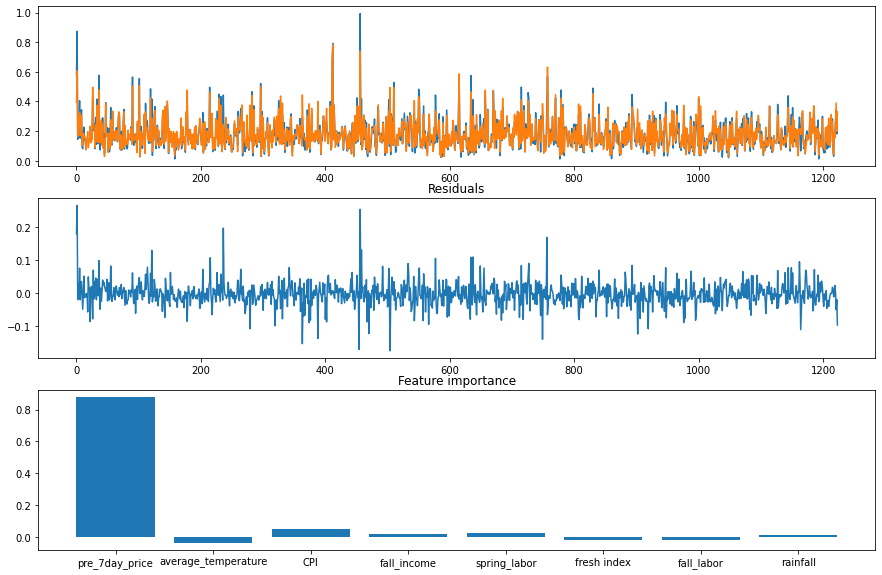

In [ ]:
# select the optimal variables ---------------------

# target variable
y = df["avg_price"]

# features
X = df[selected_variables]

# min-max scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
Y = scaler.fit_transform(y.values.reshape(-1, 1))

# split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse) 


# plot the predictions
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(y_test, label="Real")
plt.plot(y_pred, label="Predictions")

# plot the residuals
plt.subplot(3, 1, 2)
plt.plot(y_test - y_pred)
plt.title("Residuals")

# importance of features
importance = model.coef_
plt.subplot(3, 1, 3)
plt.bar(selected_variables, importance[0])
plt.title("Feature importance")
plt.show()

# plot the residuals
plt.figure(figsize=(15, 5))
plt.plot(y_test - y_pred) 


In [83]:
selected_variables

['pre_7day_price',
 'average_temperature',
 'CPI',
 'fall_income',
 'spring_labor',
 'fresh index',
 'fall_labor',
 'rainfall']

In [74]:
X_1 = sm.add_constant(X_train)
model = sm.OLS(y_train, X_1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     4156.
Date:                Fri, 08 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:36:00   Log-Likelihood:                 8943.2
No. Observations:                4893   AIC:                        -1.787e+04
Df Residuals:                    4884   BIC:                        -1.781e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0116      0.006      1.887      0.0